In [1]:
import tensorflow as tf
from tensorflow import keras  
import numpy as np
import pandas as pd
from numpy.random import randint
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

at_home = True

if at_home == True:
    checkpoint1_path = 'model_weights_home/cp-{epoch:04d}.ckpt'
    checkpoint2_path = 'binary_model_weights_home/cp-{epoch:04d}.ckpt'
else:
    checkpoint1_path = 'model_weights_uni/cp-{epoch:04d}.ckpt'
    checkpoint2_path = 'binary_model_weights_uni/cp-{epoch:04d}.ckpt'

2023-03-08 15:39:22.318773: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print('image classes')
image_classes = np.loadtxt('labels-map-proj-v3.txt',dtype=str,delimiter=' ')

print('dataframe')
df =pd.DataFrame(image_classes,columns=['filename','class'])

print('shuffling')
df = shuffle(df)

image classes
dataframe
shuffling


In [3]:
clist = [i for i in range(0,8)]
num_class = []
for i in clist:
    num_class.append(len(df[df['class']==str(i)]))
    print(len(df[df['class']==str(i)]))
print('\n',np.min(num_class))

for i in clist:
    print(i)
    df_other = df[df['class']==str(i)].sample(n=np.min(num_class), random_state=1)
    df = df.drop(df.index[(df["class"] == str(i))])
    df = pd.concat([df_other,df])
    
clist = [i for i in range(0,8)]
num_class = []
for i in clist:
    num_class.append(len(df[df['class']==str(i)]))
    print(len(df[df['class']==str(i)]))

61054
4900
1141
2331
1750
231
1148
476

 231
0
1
2
3
4
5
6
7
231
231
231
231
231
231
231
231


In [4]:
print('traintestsplit')
train_df,test_df = train_test_split(df,test_size=0.2)
train_df,val_df = train_test_split(train_df,test_size=0.5)

print('image generator')
idg = ImageDataGenerator(rescale=1./255.) # normalize
batchsize=128

print('batching')
train_ds = idg.flow_from_dataframe(dataframe=train_df, directory='map-proj-v3',batch_size=batchsize)
test_ds  = idg.flow_from_dataframe(dataframe= test_df, directory='map-proj-v3',batch_size=batchsize)
val_ds =   idg.flow_from_dataframe(dataframe=  val_df, directory='map-proj-v3',batch_size=batchsize)

traintestsplit
image generator
batching
Found 739 validated image filenames belonging to 8 classes.
Found 370 validated image filenames belonging to 8 classes.
Found 739 validated image filenames belonging to 8 classes.


In [5]:
print(df)

                                filename class
60776  ESP_049509_1075_RED-0010-r180.jpg     7
1046   PSP_003470_0930_RED-0094-r270.jpg     7
40687  ESP_046991_0950_RED-0001-r270.jpg     7
72832    ESP_049651_1050_RED-0070-fh.jpg     7
72833    ESP_049651_1050_RED-0070-fv.jpg     7
...                                  ...   ...
64703  PSP_008965_1510_RED-0406-r180.jpg     0
7948   ESP_019559_1390_RED-0102-r270.jpg     0
25200       PSP_006615_1910_RED-0182.jpg     0
49838    ESP_018493_1925_RED-0361-fv.jpg     0
7727    ESP_012677_1395_RED-0158-brt.jpg     0

[1848 rows x 2 columns]


2023-03-08 15:39:25.872269: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 15:39:25.873255: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/anaconda3/envs/tf2.11/lib::/usr/lib/nvidia:/usr/local/cuda/lib64
2023-03-08 15:39:25.902224: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusparse.so.11'; dlerror: libcusparse.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/anaconda3/envs/tf2.11/lib::/usr/lib/nvidia:/usr/local/cuda/lib64
2023-03-08 15:39:25.902271: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen 

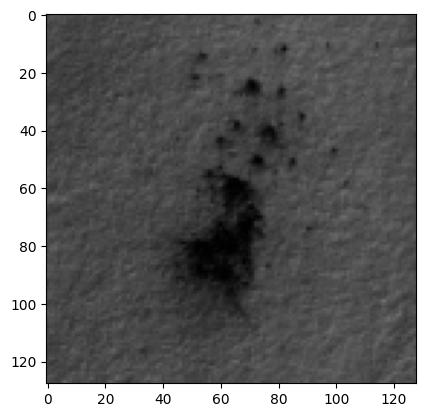

In [6]:
resize = 128
image_test = tf.image.resize(
    train_ds[0][0][0],
    [resize,resize])

plt.imshow(image_test)

In [7]:
BatchSize       = batchsize
Nepochs         = 25
DropoutValue    = 0.6 # currently unused
# set resize in previous cell

zpix = train_ds[0][0][0].shape[2] #colour

input_shape=(0,resize, resize, zpix)

model = keras.models.Sequential()

model.add(keras.layers.Lambda(lambda image:tf.image.resize(image,[resize,resize])))

model.add(keras.layers.Conv2D(16, (3, 3), padding ='same',activation='relu', input_shape=(resize, resize, zpix)))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(32, (3, 3), padding='same',activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(8, activation='softmax'))

print("--------------------------------------------------------------------------------------------------------------")
print("\033[92mWill train a convolutional neural network on the MNIST data\033[0m")
print("--------------------------------------------------------------------------------------------------------------\n\n")
print("Input data MNIST")
print("Dropout values       = ", DropoutValue)
print("Leaky relu parameter =  0.1")
print("BatchSize            = ", batchsize)
print("Nepochs              = ", Nepochs, "\n")

loss_fn = keras.losses.CategoricalCrossentropy()

model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs')
checkpoint_path = checkpoint1_path
checkpoint_dir  = os.path.dirname(checkpoint_path)
cp_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True)

model.build(input_shape) # in week 4 CNN.ipynb Abbey didn't have model.build but her summary works, how?
model.summary()

history  = model.fit(train_ds, validation_data=val_ds,batch_size=batchsize,epochs=Nepochs,callbacks=[tensorboard_callback,cp_callback])

--------------------------------------------------------------------------------------------------------------
Will train a convolutional neural network on the MNIST data
--------------------------------------------------------------------------------------------------------------


Input data MNIST
Dropout values       =  0.6
Leaky relu parameter =  0.1
BatchSize            =  128
Nepochs              =  25 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (0, 128, 128, 3)          0         
                                                                 
 conv2d (Conv2D)             (0, 128, 128, 16)         448       
                                                                 
 max_pooling2d (MaxPooling2D  (0, 64, 64, 16)          0         
 )                                                               
                                      

6/6 [==============================] - ETA: 0s - loss: 1.8022 - accuracy: 0.3058
Epoch 20: saving model to model_weights_home/cp-0020.ckpt
6/6 [==============================] - 8s 1s/step - loss: 1.8022 - accuracy: 0.3058 - val_loss: 1.8923 - val_accuracy: 0.2882
Epoch 21/25
6/6 [==============================] - ETA: 0s - loss: 1.7810 - accuracy: 0.2991
Epoch 21: saving model to model_weights_home/cp-0021.ckpt
6/6 [==============================] - 8s 1s/step - loss: 1.7810 - accuracy: 0.2991 - val_loss: 1.8534 - val_accuracy: 0.2842
Epoch 22/25
6/6 [==============================] - ETA: 0s - loss: 1.7532 - accuracy: 0.3207
Epoch 22: saving model to model_weights_home/cp-0022.ckpt
6/6 [==============================] - 8s 1s/step - loss: 1.7532 - accuracy: 0.3207 - val_loss: 1.8454 - val_accuracy: 0.3112
Epoch 23/25
6/6 [==============================] - ETA: 0s - loss: 1.7350 - accuracy: 0.3302
Epoch 23: saving model to model_weights_home/cp-0023.ckpt
6/6 [=========================

In [8]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
model.load_weights(latest)
loss, acc = model.evaluate(test_ds)

3/3 [==============================] - 3s 1s/step - loss: 1.8103 - accuracy: 0.3000


history keys =  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Display the evolution of the accuracy as a function of the training epoch
  N(Epochs)        =  25
  accuracy (train) =  [0.1204330176115036, 0.12990528345108032, 0.15290933847427368, 0.12990528345108032, 0.13531799614429474, 0.17997293174266815, 0.2016238123178482, 0.23545332252979279, 0.21380244195461273, 0.22598105669021606, 0.25033828616142273, 0.23545332252979279, 0.2381596714258194, 0.2719891667366028, 0.2449255734682083, 0.26116374135017395, 0.282814621925354, 0.26792964339256287, 0.2422192096710205, 0.30581867694854736, 0.29905277490615845, 0.3207036554813385, 0.33017590641975403, 0.29364004731178284, 0.33558863401412964]
  accuracy (test)  =  [0.1217861995100975, 0.1637347787618637, 0.17726658284664154, 0.1610284149646759, 0.1962110996246338, 0.21515561640262604, 0.22056832909584045, 0.22192151844501495, 0.21380244195461273, 0.20974288880825043, 0.20974288880825043, 0.1948579102754593, 0.2070365399122

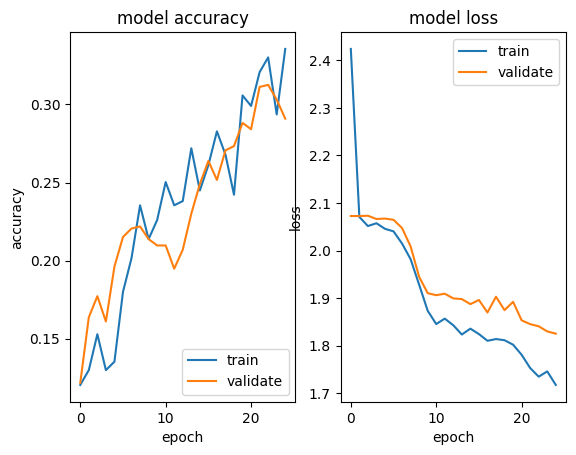

In [9]:
# Print out the history keys expected are:
#    loss        The loss function evaluated at each epoch for the training set
#    acc         The accuracy evaluated at each epoch for the training set
#    val_loss    The loss evaluated at each epoch for the validation set
#    val_acc     The accuracy evaluated at each epoch for the validation set
# The val_* entries exist only if there is a validation_split specified

print("history keys = ", history.history.keys())

print("\n\033[1mDisplay the evolution of the accuracy as a function of the training epoch\033[0m")
print("  N(Epochs)        = ", Nepochs)

print("  accuracy (train) = ", history.history['accuracy'])
print("  accuracy (test)  = ", history.history['val_accuracy'])
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')

print("\n\033[1mDisplay the evolution of the loss as a function of the training epoch\033[0m")
print("  N(Epochs)        = ", Nepochs)
print("  loss (train)     = ", history.history['loss'])
#print("  loss (test)      = ", history.history['val_loss'])

# summarize history for loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

In [10]:
predictions = model.predict(test_ds)

3/3 [==============================] - 1s 404ms/step


In [11]:
import csv

# Create an empty dictionary to store the data
data_dict = {}

with open('landmarks_map-proj-v3_classmap.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        # Get the number and word values from the current row
        num = int(row[0])
        word = row[1]
        # Add the values to the dictionary
        data_dict[num] = word

In [12]:
print(data_dict[4])

bright dune


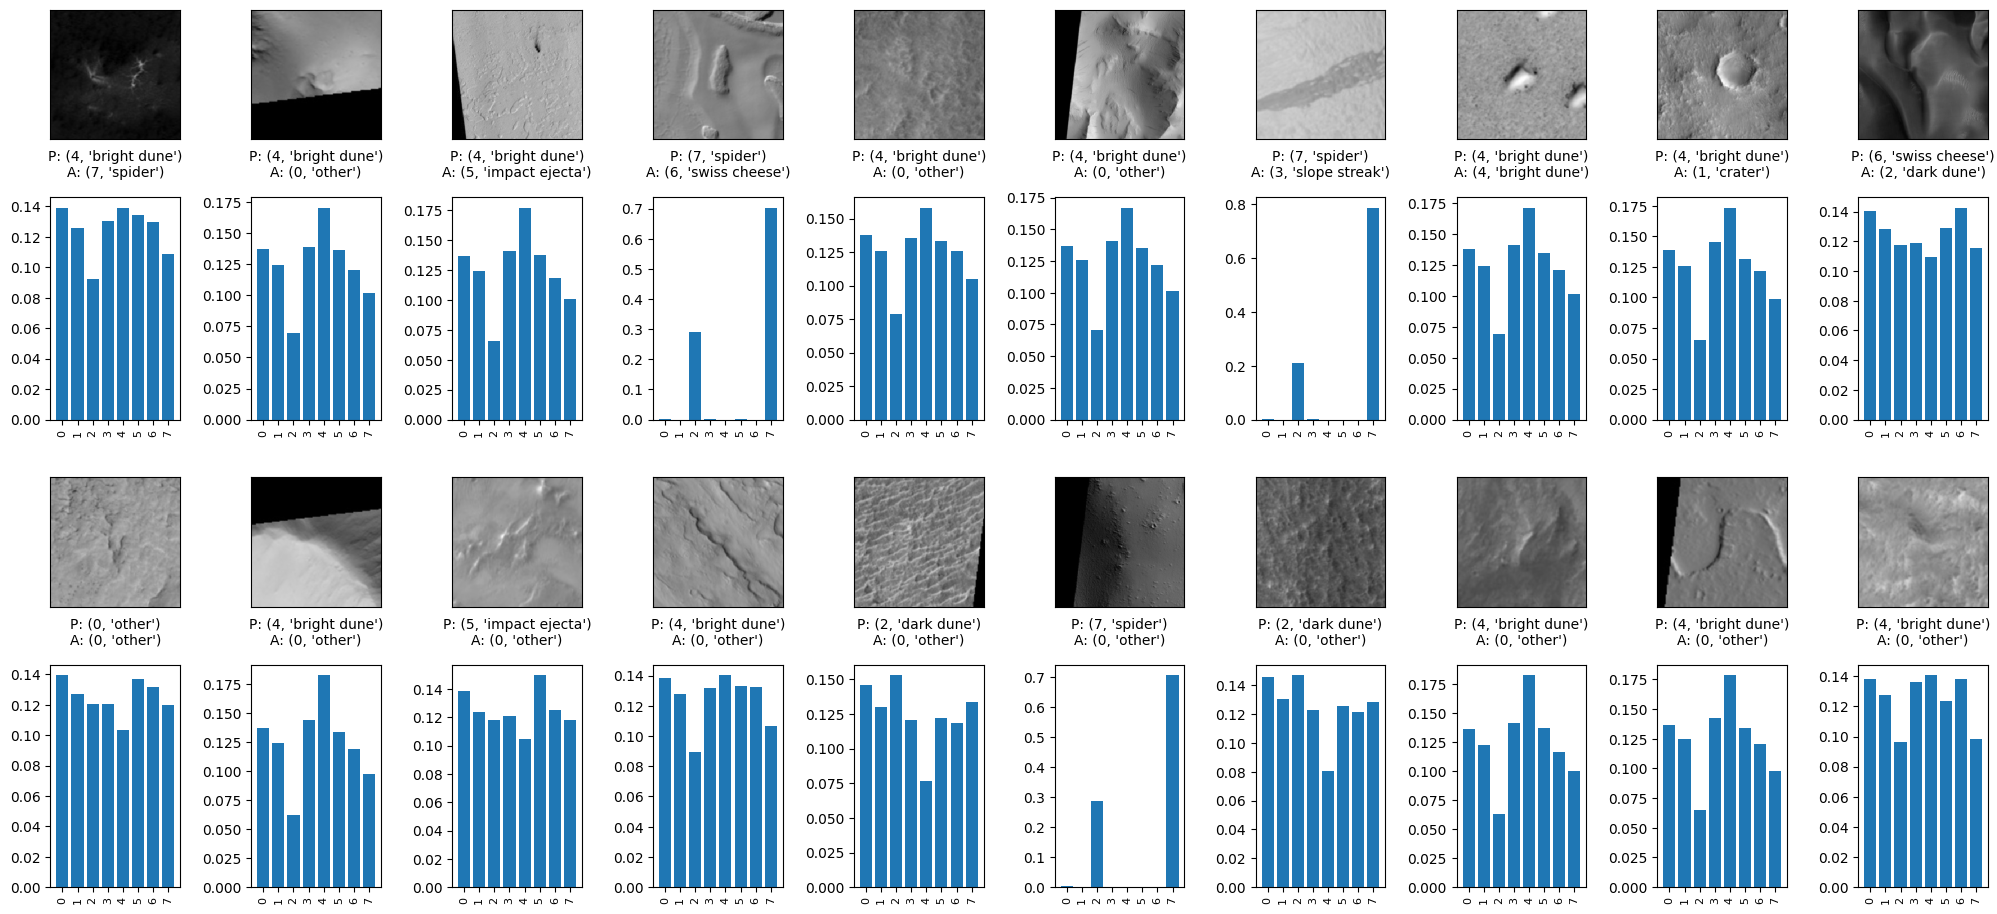

In [13]:
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(25, 12))
class_list = [i for i in range(0,8)]

rand_list = list(randint(0,1,12))
for i in rand_list:
    class_list.append(i)
count = 0
j = 0
x,y = 0,1
image_count = 0
for i in test_ds:
    image_count = 0
    for k in i[1]:
        prediction = predictions[count]
        actual = np.argmax(k)
        if np.isin(actual,class_list):

            axes[x][j].imshow(i[0][image_count])
            axes[x][j].set_xticks([])
            axes[x][j].set_yticks([])

            # Set the x axis label
            axes[x][j].set_xlabel(f"P: {np.argmax(prediction),data_dict[int(np.argmax(prediction))]}\nA: {actual, data_dict[actual]}",fontsize=10)

            # Add some space between subplots
            plt.subplots_adjust(wspace=0.55)
            plt.subplots_adjust(hspace=0.05)

            # Plot the predicted probabilities as a bar graph
            axes[y][j].bar([0,1,2,3,4,5,6,7],prediction)
            axes[y][j].set_xticks([0,1,2,3,4,5,6,7])
            axes[y][j].set_xticklabels([0,1,2,3,4,5,6,7], rotation=90, fontsize=8)

            class_list.remove(int(actual))

            j += 1
    
        image_count += 1
        count += 1

        if len(class_list) == 10:
            x,y,j=2,3,0
        if class_list == []:
            break
    if class_list == []:
        break

In [14]:
abs_predictions = np.argmax(predictions,axis=1)
test_df['models class'] = abs_predictions
test_df.head(20)
print(len(abs_predictions))

370


[24.489795918367346, 0.0, 12.5, 7.142857142857142, 38.46153846153847, 10.526315789473683, 8.19672131147541, 19.148936170212767]


Text(0, 0.5, 'prediction accuracy percentage')

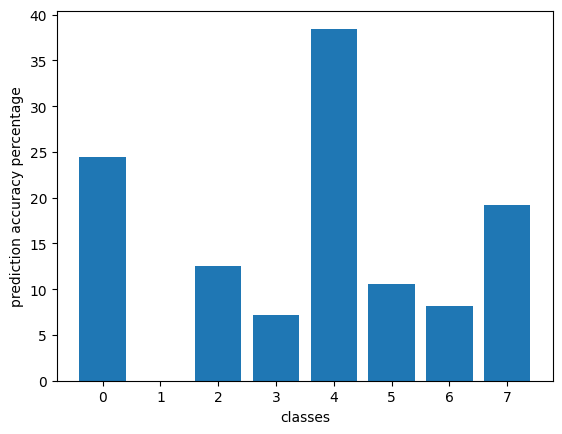

In [15]:
# for some reason class was a column of strings... took ages to figure that out
test_df['class'] = test_df['class'].astype(int)
class_list = [i for i in range(0,8)]

accuracy_list = []
for i in class_list:
    
    df_0 = test_df.loc[test_df['class'] == i]
    num_identical = sum(df_0['class'] == df_0['models class'])
    num_rows = len(df_0)
    percent_identical = num_identical / num_rows * 100
    accuracy_list.append(percent_identical)

print(accuracy_list)
plt.bar(class_list,accuracy_list)
plt.xlabel('classes')
plt.ylabel('prediction accuracy percentage')

### changing to is/is not:[dune]

In [16]:
print('image classes')
image_classes = np.loadtxt('labels-map-proj-v3.txt',dtype=str,delimiter=' ')

print('dataframe')
df =pd.DataFrame(image_classes,columns=['filename','class'])

print('shuffling')
df = shuffle(df)

# Replace non-dune class labels with 0 & again with the string values for class. whyyyyyyyyyyy
print('reformatting')
df['class'] = df['class'].astype(int)
df.loc[~df['class'].isin([2, 4]), 'class'] = 0
df.loc[df['class'].isin([2, 4]), 'class']  = 1
df['class'] = df['class'].astype(str)

clist = [0,1]
num_class = []
for i in clist:
    num_class.append(len(df[df['class']==str(i)]))
    print(f'length of class: {i}',len(df[df['class']==str(i)]))
print('min class count',np.min(num_class))

for i in clist:
    df_other = df[df['class']==str(i)].sample(n=np.min(num_class), random_state=1)
    df = df.drop(df.index[(df["class"] == str(i))])
    df = pd.concat([df_other,df])
    
clist = [0,1]
num_class = []
for i in clist:
    num_class.append(len(df[df['class']==str(i)]))
    print(f'length of class: {i}',len(df[df['class']==str(i)]))

image classes
dataframe
shuffling
reformatting
length of class: 0 70140
length of class: 1 2891
min class count 2891
length of class: 0 2891
length of class: 1 2891


In [17]:
print('traintestsplit')
train_df,test_df = train_test_split(df,test_size=0.2)
train_df,val_df = train_test_split(train_df,test_size=0.5)

print('image generator')
idg = ImageDataGenerator(rescale=1./255.) # normalize
batchsize=128

print('batching')
train_ds = idg.flow_from_dataframe(dataframe=train_df, directory='map-proj-v3',batch_size=batchsize)
test_ds  = idg.flow_from_dataframe(dataframe= test_df, directory='map-proj-v3',batch_size=batchsize)
val_ds =   idg.flow_from_dataframe(dataframe=  val_df, directory='map-proj-v3',batch_size=batchsize)

traintestsplit
image generator
batching
Found 2312 validated image filenames belonging to 2 classes.
Found 1157 validated image filenames belonging to 2 classes.
Found 2313 validated image filenames belonging to 2 classes.


In [18]:
BatchSize       = batchsize
Nepochs         = 10
resize = 128
DropoutValue    = 0.6 # currently unused
# set resize in previous cell

zpix = train_ds[0][0][0].shape[2] #colour

input_shape=(0,resize, resize, zpix)

model = keras.models.Sequential()

model.add(keras.layers.Lambda(lambda image:tf.image.resize(image,[resize,resize])))

model.add(keras.layers.Conv2D(32, (3, 3), padding ='same',activation='relu', input_shape=(resize, resize, zpix)))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(125, (3, 3), padding='same',activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(2, activation='sigmoid'))

print("--------------------------------------------------------------------------------------------------------------")
print("\033[92mWill train a convolutional neural network on the MNIST data\033[0m")
print("--------------------------------------------------------------------------------------------------------------\n\n")
print("Input data MNIST")
print("Dropout values       = ", DropoutValue)
print("Leaky relu parameter =  0.1")
print("BatchSize            = ", batchsize)
print("Nepochs              = ", Nepochs, "\n")


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs')
checkpoint_path = checkpoint2_path
checkpoint_dir  = os.path.dirname(checkpoint_path)
cp_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True)

model.build(input_shape) 
model.summary()

history  = model.fit(train_ds, validation_data=val_ds,batch_size=batchsize,epochs=Nepochs,callbacks=[tensorboard_callback,cp_callback])

--------------------------------------------------------------------------------------------------------------
Will train a convolutional neural network on the MNIST data
--------------------------------------------------------------------------------------------------------------


Input data MNIST
Dropout values       =  0.6
Leaky relu parameter =  0.1
BatchSize            =  128
Nepochs              =  10 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (0, 128, 128, 3)          0         
                                                                 
 conv2d_3 (Conv2D)           (0, 128, 128, 32)         896       
                                                                 
 max_pooling2d_3 (MaxPooling  (0, 64, 64, 32)          0         
 2D)                                                             
                                    

history keys =  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Display the evolution of the accuracy as a function of the training epoch
  N(Epochs)        =  10
  accuracy (train) =  [0.49221453070640564, 0.6055363416671753, 0.5882353186607361, 0.6647923588752747, 0.724913477897644, 0.7820069193840027, 0.8269895911216736, 0.8438581228256226, 0.9031141996383667, 0.9165225028991699]
  accuracy (test)  =  [0.5036748647689819, 0.6173800230026245, 0.7137916088104248, 0.688715934753418, 0.7388672828674316, 0.7959359884262085, 0.8469520211219788, 0.8469520211219788, 0.8707306385040283, 0.8521400690078735]

Display the evolution of the loss as a function of the training epoch
  N(Epochs)        =  10
  loss (train)     =  [0.7417826056480408, 0.663392961025238, 0.6576985716819763, 0.6217828989028931, 0.5699547529220581, 0.4744701385498047, 0.4143623411655426, 0.371599942445755, 0.25833696126937866, 0.22318805754184723]


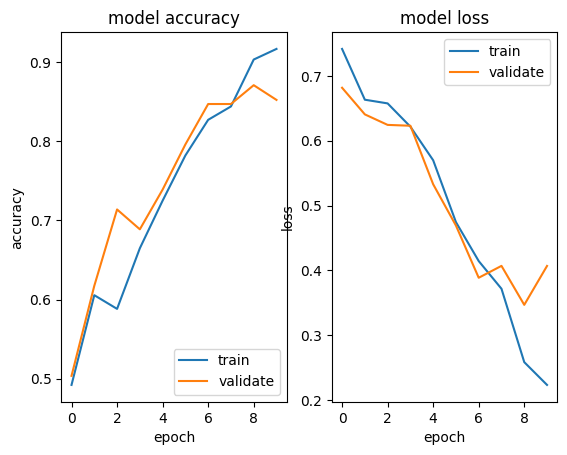

In [19]:
# Print out the history keys expected are:
#    loss        The loss function evaluated at each epoch for the training set
#    acc         The accuracy evaluated at each epoch for the training set
#    val_loss    The loss evaluated at each epoch for the validation set
#    val_acc     The accuracy evaluated at each epoch for the validation set
# The val_* entries exist only if there is a validation_split specified

print("history keys = ", history.history.keys())

print("\n\033[1mDisplay the evolution of the accuracy as a function of the training epoch\033[0m")
print("  N(Epochs)        = ", Nepochs)

print("  accuracy (train) = ", history.history['accuracy'])
print("  accuracy (test)  = ", history.history['val_accuracy'])
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')

print("\n\033[1mDisplay the evolution of the loss as a function of the training epoch\033[0m")
print("  N(Epochs)        = ", Nepochs)
print("  loss (train)     = ", history.history['loss'])
#print("  loss (test)      = ", history.history['val_loss'])

# summarize history for loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

In [20]:
old_predictions = model.predict(test_ds)

10/10 [==============================] - 5s 452ms/step


In [21]:
'''predictions = []
print(old_predictions)
for i in old_predictions:
    predictions.append(np.argmax(i))'''
'''print(old_predictions,np.mean(old_predictions))
predictions = np.where(old_predictions >= np.mean(old_predictions), 1, 0)
print(predictions[0:10])'''

'print(old_predictions,np.mean(old_predictions))\npredictions = np.where(old_predictions >= np.mean(old_predictions), 1, 0)\nprint(predictions[0:10])'

In [22]:
'''print(len(predictions))
test_df.loc[test_df['class'].isin(['2', '4']), 'class'] = 1
test_df.loc[test_df['class'].isin(['0']), 'class'] = 0
print(test_df[test_df['class']=='0'])
print(test_df[test_df['class']=='1'])
test_df['class'] = test_df['class'].astype(int)
test_df['class'] = test_df['class'].astype(bool)
print(test_df[test_df['class']==True])
print(test_df[test_df['class']==False])
my_classlist = test_df['class'].to_numpy()'''

"print(len(predictions))\ntest_df.loc[test_df['class'].isin(['2', '4']), 'class'] = 1\ntest_df.loc[test_df['class'].isin(['0']), 'class'] = 0\nprint(test_df[test_df['class']=='0'])\nprint(test_df[test_df['class']=='1'])\ntest_df['class'] = test_df['class'].astype(int)\ntest_df['class'] = test_df['class'].astype(bool)\nprint(test_df[test_df['class']==True])\nprint(test_df[test_df['class']==False])\nmy_classlist = test_df['class'].to_numpy()"

In [23]:
predictions = []
for i in old_predictions:
    predictions.append(i[1])
print(predictions)

[0.9607055, 0.9593916, 0.6872719, 0.5763996, 0.5094229, 0.98319644, 0.02293598, 0.33650488, 0.97136205, 0.9013941, 0.20189863, 0.85793215, 0.99286705, 0.98175734, 0.70348036, 0.12881432, 0.9957676, 0.015601844, 0.98999375, 0.98490864, 0.9596281, 0.044658426, 0.76, 0.009200242, 0.9062949, 0.10722508, 0.99881643, 0.078885786, 0.18217717, 0.03702108, 0.8868997, 0.8013437, 0.9992954, 0.9904383, 0.2611411, 0.10096964, 0.9546192, 0.9998674, 0.9961227, 0.34945136, 0.70588684, 0.9999982, 0.062069077, 0.0061804717, 0.9096437, 0.2581195, 0.3131047, 0.021684619, 0.999021, 0.9999531, 0.9803056, 0.024061201, 1.0, 0.99682516, 0.17025195, 0.5632584, 0.88985, 0.48022112, 0.36886206, 0.048508517, 0.9967511, 0.5310219, 0.7239145, 0.27630466, 0.937349, 0.47257408, 0.022459157, 0.16806673, 0.99968183, 0.22754158, 0.9576489, 0.98440546, 0.93870133, 0.98024774, 0.03664873, 0.9876565, 0.19012986, 0.1723214, 0.016891103, 0.9959736, 0.6776034, 0.956133, 0.82628304, 0.85318726, 0.014986383, 0.12239189, 0.991974

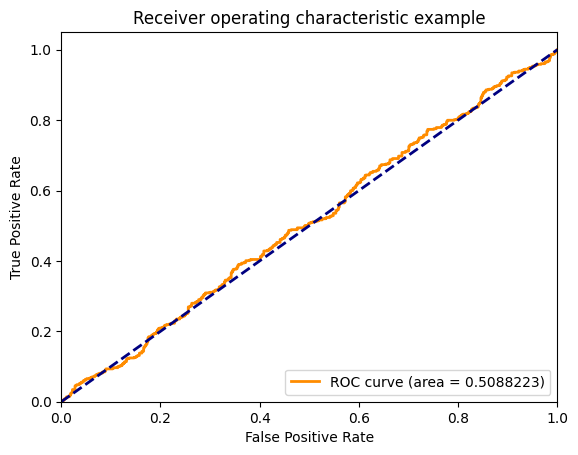

In [24]:
fpr, tpr, _ = roc_curve(test_ds.classes, predictions)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.7f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()